# Introduction
In this assignment, you are going to train a neural network to **predict a likely language of origin for a last name**.


- Learn to preprocess raw text so it can be fed into an RNN and LSTM;
- Make use of relevant libraries in Pytorch;
- Train, evaluate, and generate predictions for unseen data.

Disclaimer: the predicted language of origin reveals no assumptions about the person's nationality or ethnicity. 


# Library imports

Before starting, make sure you have all these libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# cd into the correct drive folder
%cd drive/MyDrive/GSI/GNN_RNN/hw3_sp

/content/drive/MyDrive/GSI/GNN_RNN/hw3_sp


In [3]:
root_folder = ""
import os
import sys
sys.path.append(root_folder)
from collections import Counter
import torch as th
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import json

import matplotlib.pyplot as plt
# from utils import validate_to_array

device = th.device("cuda" if th.cuda.is_available() else "cpu")

import IPython
from ipywidgets import interactive, widgets, Layout
from IPython.display import display, HTML

In [4]:
%load_ext autoreload
%autoreload 2

# Part A: Creating the Network

The problem is predicting the $$ P ( class | c_1, c_2, c_3, ..., c_i), \forall i \in name $$

The advantage of building basic character-level NLP model is that you can see how preprocessing works at a low level. A character-level network reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step. We take the final prediction to be the output, i.e. which class the word belongs to.

All models in PyTorch inherit from the subclass nn.Module. Here, you will intialize a custom model called RecurrentClassifier to run [nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) or [nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html), and define its forward function. Note: set batch_first in the arguments to the above to True.

In [25]:
n_categories

18

In [5]:
# Using a basic RNN/LSTM for Language modeling
# TODO: Add hint of using pytorch funcs
class RecurrentClassifier(nn.Module):
    def __init__(self, vocab_size, rnn_size, n_categories, num_layers=1, dropout=0, model_type='lstm'):
        super().__init__()
        # Create an embedding layer of shape [vocab_size, rnn_size]
        # Use nn.Embedding
        # That will map each word in our vocab into a vector of rnn_size size.
        self.model_type = model_type

        self.embedding = nn.Embedding(vocab_size, rnn_size) 

        # Create an LSTM layer of rnn_size size. Use any features you wish.
        # We will be using batch_first convention
        if model_type == 'lstm':
            self.lstm = nn.LSTM(rnn_size,
                                rnn_size,
                                num_layers=num_layers,
                                dropout=dropout,
                                batch_first=True,) 
        elif model_type == 'rnn':
            self.rnn = nn.RNN(rnn_size,
                                rnn_size,
                                num_layers=num_layers,
                                dropout=dropout,
                                batch_first=True,)
        # LSTM layer does not add dropout to the last hidden output.
        # Add this if you wish.
        # self.dropout = nn.Dropout(p=dropout)
        # Use a dense layer to project the outputs of the RNN cell into logits of
        # size n_categories
        self.output = nn.Linear(rnn_size, n_categories)

    def forward(self,x):
        embeds = self.embedding(x)
        if self.model_type == 'lstm':
            lstm_out, _ = self.lstm(embeds)
            logits = self.output(lstm_out)
        else:
            rnn_out, _ = self.rnn(embeds)
            logits = self.output(rnn_out)
        return logits


# Part B: Preprocessing the dataset
The [dataset](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) contains a few thousand surnames from 18 languages of origin. Included in the data/names directory are 18 text files named as "[Language].txt". Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We'll end up with a dictionary of lists of names per language, {language: [names ...]}. 

Fill in the TODO's in the following cells.




In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/English.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Irish.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Greek.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Italian.txt', 'data/names/Dutch.txt', 'data/names/German.txt', 'data/names/Spanish.txt', 'data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/Korean.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt']
Slusarski


In [7]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [8]:
# TODO: Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

In [9]:
# For labels, we must have numbers instead of a string. These dictionaries convert
# between these two ways of representing the labels.
num_to_cat = dict(enumerate(category_lines.keys()))
cat_to_num = dict((v,k) for k,v in num_to_cat.items())

pad = 57 # this is the next available character 
vocab_size = 58 # number of characters used in total

In [10]:
def build_data():
  '''
  category_lines: a dictionary of lists of names per language, {language: [names ...]}. 

  We want to translate our dictionary into a dataset that has one entry per name. 
  Each datapoint is a 3-tuple consisting of: 
  - x: a length-19 array with each character in the name as an element,
   padded with zeros at the end if the name is less than 19 characters.
  - y: the numerical representation of the language the name corresponds to.
  - index: the index of the last non-pad token
  '''
  data = []
  for cat in category_lines:
    for name in category_lines[cat]:
      token = np.ones(19) * pad
      numerized = np.array([letterToIndex(l) for l in name])
      n = len(numerized)
      token[:n] = numerized
      data.append((token, cat_to_num[cat], n-1))
  return data

In [11]:
data = build_data()
random.shuffle(data)

In [12]:
n_train = int(len(data) * 0.8)
train_data = data[:n_train]
test_data = data[n_train:]

# Part C: Training the model

Fill in the TODO's below. 

Training will be faster if you use the Colab GPU. If it's not already enabled, do so with Runtime -> Change runtime type.

Look at the training loss curves of RNN vs. LSTM. Which one does better? 

In [13]:
def build_batch(dataset, indices):
    '''
    Helper function for creating a batch during training. Builds a batch 
    of source and target elements from the dataset. See the next cell for 
    when and how it's used. 
    
    Arguments:
        dataset: List[db_element] -- A list of dataset elements
        indices: List[int] -- A list of indices of the dataset to sample
    Returns:
        batch_input: List[List[int]] -- List of tensorized names
        batch_target: List[int] -- List of numerical categories
        batch_indices: List[int] -- List of starting indices of padding
    '''
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    batch_input = np.array(list(zip(*batch))[0])
    batch_target = np.array(list(zip(*batch))[1])
    batch_indices = np.array(list(zip(*batch))[2])
    return batch_input, batch_target, batch_indices # lines, categories
#validate_to_array(build_batch,(d_train, range(100)),'build_batch',root_folder)

In [14]:
# The logits are the output_logits we've computed,
# The targets are the goal labels we are trying to match.
# here we will take the mean of all non-pad tokens together.
criterion = nn.CrossEntropyLoss() # TODO: setup the loss using cross-entropy loss.
def loss_fn(pred, target, index):
    pred_valid = pred[np.arange(len(pred)),index,:]
    loss_tensor = criterion(pred_valid, target)
    return loss_tensor

# The build_batch function outputs numpy, but our model is built in pytorch,
# so we need to convert numpy to pytorch with the correct types. 
batch_to_torch = lambda b_in,b_target,b_mask: (th.tensor(b_in).long(),
                                               th.tensor(b_target).long(), 
                                               th.tensor(b_mask).long())

# Model parameters. You can tune this for better performance. 
hidden_size = 256
num_layers = 3
dropout = .5
optimizer_class = optim.Adam
lr = 1e-3
epochs = 15
batch_size = 128

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)
list_to_device = lambda th_obj: [tensor.to(device) for tensor in th_obj]

cuda


In [15]:
lstm_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='lstm')
lstm_optimizer = optimizer_class(lstm_model.parameters(), lr=lr)

In [16]:
rnn_model = RecurrentClassifier(vocab_size=vocab_size, rnn_size=hidden_size, n_categories=n_categories, num_layers=num_layers, dropout=dropout, model_type='rnn')
rnn_optimizer = optimizer_class(rnn_model.parameters(), lr=lr)

In [22]:
def train(model, optimizer, epochs, model_id='test_1'):
  '''
  Train and save a model.
  '''
  model.train()
  losses = []
  eval_losses = []
  accuracies = []
  from tqdm import tqdm
  for epoch in range(epochs):
      indices = np.random.permutation(range(len(train_data)))
      t = tqdm(range(0,(len(train_data)//batch_size)+1))
      for i in t:
          # Here is how you obtain a batch:
          batch = build_batch(train_data, indices[i*batch_size:(i+1)*batch_size])
          (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
          (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))
          model.to(device)
          print(batch_input[0])
          prediction = model(batch_input)
          loss = loss_fn(prediction, batch_target, batch_indices)
          losses.append(loss.item())
          pred_valid = prediction[np.arange(len(prediction)),batch_indices,:]
          accuracy = th.mean(th.eq(pred_valid.argmax(dim=1,keepdim=False),batch_target).float())
          accuracies.append(accuracy.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          if i % 10 == 0:
              t.set_description(f"Epoch: {epoch} Iteration: {i} Loss: {np.mean(losses[-10:])} Accuracy: {np.mean(accuracies[-10:])}")
              if eval:
                batch = build_batch(test_data, range(len(test_data)))
                (batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
                (batch_input, batch_target, batch_indices) = list_to_device((batch_input, batch_target, batch_indices))
                prediction = model(batch_input.long())
                loss = loss_fn(prediction, batch_target, batch_indices)
                eval_losses.append(loss.item())
      # TODO: save your latest model with a UNIQUE model name if you need to access
      # it later! 
      model_id = 'test11'
      os.makedirs(root_folder+'models/part1',exist_ok=True)        
      save_dict = dict(
          kwargs = dict(
              vocab_size=vocab_size,
              rnn_size=hidden_size,
              n_categories=n_categories,
              num_layers=num_layers,
              dropout=dropout
          ),
          model_state_dict = model.state_dict(),
          notes = "",
          optimizer_class = optimizer_class,
          lr = lr,
          epochs = epochs,
          batch_size = batch_size,
      )
      th.save(save_dict,root_folder+f'models/part1/model_{model_id}.pt')
  return losses

In [23]:
batch_input[0]

NameError: ignored

In [24]:
losses = train(lstm_model, lstm_optimizer, epochs, 'test_lstm')

Epoch: 0 Iteration: 0 Loss: 1.1578385829925537 Accuracy: 0.6796875:   1%|          | 1/126 [00:00<00:17,  7.27it/s]

tensor([38, 14, 18,  2,  7,  4, 11, 11,  0, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([41,  4,  2,  7,  4, 17, 10,  8, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([44,  7,  0, 11,  7, 14, 20,  1, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([35,  4, 17, 14, 13, 10,  8, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([31,  0,  4, 17,  1,  4, 17, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')


Epoch: 0 Iteration: 10 Loss: 1.1960484027862548 Accuracy: 0.66171875:   6%|▋         | 8/126 [00:00<00:03, 36.89it/s]

tensor([38, 17,  4, 21, 11,  8, 18,  7, 21,  8, 11,  8, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26,  6,  0, 15,  7, 14, 13, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([43,  0,  7, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([31, 14, 17, 19, 20, 13, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([45,  7,  8, 17, 11, 22,  0, 11, 11, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([47, 24,  0,  2,  7,  4, 18, 11,  0, 21, 14, 21, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')


Epoch: 0 Iteration: 20 Loss: 1.1957873702049255 Accuracy: 0.65625:  16%|█▌        | 20/126 [00:00<00:02, 42.90it/s]   

tensor([41, 14, 17, 19, 13, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26,  3,  0, 12, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([39,  0, 15, 14, 11,  4, 14, 13,  8, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([32,  4, 17,  6,  4, 18, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([38, 20, 10, 18, 20, 13, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([28,  7,  0, 13,  6, 11,  8, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([36, 14,  2,  8, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([41,  0, 17,  0, 13,  8, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([29,  0,  4, 11, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26

Epoch: 0 Iteration: 30 Loss: 1.1991093635559082 Accuracy: 0.67578125:  25%|██▍       | 31/126 [00:00<00:02, 40.29it/s]

tensor([29, 56,  2, 17, 20, 25, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([44,  7,  8,  1,  0, 13, 20, 12,  0, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([43, 14,  0,  2,  7, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([27,  0,  8,  6, 20, 25, 14,  5,  5, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([36, 14, 25, 20, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([29, 25,  7,  0, 13,  0, 10,  0, 21, 14, 21, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26, 11, 12,  0, 18,  8, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([38, 20, 10, 11,  4, 21,  8,  2,  7, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([48,  4, 13,  3,  4, 11, 11, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([33

Epoch: 0 Iteration: 40 Loss: 1.2103747963905334 Accuracy: 0.65390625:  32%|███▏      | 40/126 [00:00<00:01, 51.85it/s]

tensor([50,  0,  3, 17,  8, 10,  7,  8, 13, 18, 10, 24, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([40, 14, 17, 18,  2,  7, 14, 19, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([44,  0, 17, 10,  8, 18, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26, 13, 20, 17,  8, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([30,  0, 19, 17, 14, 18, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([32,  0, 20, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([43,  4,  0,  3, 12,  0, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([35,  4, 11, 21,  0, 10, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([47,  0, 11, 11,  0, 13,  3,  4, 17, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([51

Epoch: 0 Iteration: 50 Loss: 1.055009526014328 Accuracy: 0.70390625:  41%|████▏     | 52/126 [00:01<00:01, 45.86it/s]

tensor([44,  7,  0, 12, 14, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26,  1,  0, 18,  7,  4, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([41, 14, 17, 17,  0, 18, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([28,  7,  8, 13, 14, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([44,  2,  7, 13,  4,  8,  3,  4, 17, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([35,  8,  6,  0,  8, 11, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([37, 14, 22,  4, 18, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([37, 14, 22,  4, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([29, 20,  1,  8, 19, 18, 10, 24, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([44

Epoch: 0 Iteration: 60 Loss: 1.025054508447647 Accuracy: 0.7125:  48%|████▊     | 61/126 [00:01<00:01, 47.01it/s]

tensor([33,  0,  4, 18,  7, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([38,  0, 18,  8,  7, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([28, 17, 20, 12, 15, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26, 11,  7,  8, 12,  4, 13, 10, 14, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([48,  4, 11,  3, 14, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([43, 14, 21,  1,  4, 11, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([33,  0, 17,  0,  3, 25,  4, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([34,  3,  0, 13,  4, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([48, 14, 11,  5,  5, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([38

Epoch: 0 Iteration: 70 Loss: 0.9849708676338196 Accuracy: 0.7234375:  55%|█████▍    | 69/126 [00:01<00:01, 54.29it/s]

tensor([43, 20, 25,  0, 21,  8, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([34, 21,  0, 13, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([50,  0, 10, 14, 21,  2,  7, 20, 10, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([30,  0, 17,  8, 13,  6, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([45,  0, 10,  0, 10,  8, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([35,  0, 17, 12, 20,  7,  0, 12,  4,  3, 14, 21, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([30,  1,  4, 17, 18, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([37,  4,  9,  0, 13, 10, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([32,  8,  0, 13, 13,  0, 10, 14, 18, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([31

Epoch: 0 Iteration: 80 Loss: 1.0347998321056366 Accuracy: 0.70078125:  64%|██████▍   | 81/126 [00:01<00:00, 47.01it/s]

tensor([32,  0, 18, 19,  4, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([33,  0, 19,  0,  6, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26,  2,  2, 14, 17, 18,  8, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([29,  4,  4,  1, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([39,  0,  9,  9,  0, 17, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([43,  8, 21,  4, 17, 18, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([38,  0, 19, 18, 20,  3,  0, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26, 13,  3, 17, 20,  7, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([29,  0, 21, 11,  4, 19, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([39

Epoch: 0 Iteration: 90 Loss: 0.9861133396625519 Accuracy: 0.725:  75%|███████▌  | 95/126 [00:02<00:00, 49.18it/s]

tensor([47, 24, 18, 19,  0, 21, 10,  8, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([34, 18, 11,  0, 13, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([33,  0,  0, 13, 17,  0,  3,  4, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26, 19,  8, 24,  4,  7, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([27,  4, 18, 18, 14, 13, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26, 19,  0, 11,  8,  0, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([45,  2,  7,  0, 13,  2,  7,  8, 10, 14, 21, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([41, 14, 17, 20,  1, 11,  4, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([39,  8, 25,  7,  8, 13, 18, 10, 24, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([29

Epoch: 0 Iteration: 100 Loss: 1.0056352853775024 Accuracy: 0.71015625:  80%|████████  | 101/126 [00:02<00:00, 45.69it/s]

tensor([44,  7,  0, 11, 12,  0, 13, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([39,  8,  5, 19,  4, 17,  8, 10, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([45, 14, 19,  0,  7, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([36,  0,  1, 20, 11, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26, 17, 19, 24, 20, 18,  7,  8, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([27,  4, 18, 19, 20,  9,  4, 21, 37,  0,  3,  0, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([44,  0, 17, 10, 14, 25, 24, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([35,  4, 11, 24,  0,  1, 14, 21, 18, 10, 24, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([27,  0, 17, 19, 14, 11, 14, 12,  4, 14, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([32

Epoch: 0 Iteration: 110 Loss: 0.9461038708686829 Accuracy: 0.734375:  91%|█████████▏| 115/126 [00:02<00:00, 49.25it/s]

tensor([38,  0, 17, 14, 20, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([44,  0, 12, 20,  4, 11, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([33,  0, 12,  0,  2,  7, 14, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([29,  4, 12,  4, 18,  7, 10, 14, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([37, 24, 18,  4, 13, 13, 24, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([29, 25,  7,  0, 17,  8, 12, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([35, 20, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([26, 22,  0, 10, 24,  0, 13, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([45, 14, 12,  0, 18,  7, 15, 14, 11, 18, 10, 24, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([29

Epoch: 0 Iteration: 120 Loss: 0.8975281357765198 Accuracy: 0.7515625:  95%|█████████▌| 120/126 [00:02<00:00, 47.04it/s]


tensor([27,  4, 11, 14,  4, 13, 10, 14, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([45,  0, 10,  0, 18,  7,  8, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([35, 20, 17,  0, 21, 11,  8, 14, 21, 57, 57, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')
tensor([27,  0,  8, 19,  4, 17, 24,  0, 10, 14, 21, 57, 57, 57, 57, 57, 57, 57,
        57], device='cuda:0')


KeyboardInterrupt: ignored

In [ ]:
rnn_losses = train(rnn_model, rnn_optimizer, epochs, 'test_rnn')

Epoch: 0 Iteration: 120 Loss: 1.0675450086593627 Accuracy: 0.69296875: 100%|██████████| 126/126 [00:00<00:00, 134.16it/s]
Epoch: 1 Iteration: 120 Loss: 0.8010131657123566 Accuracy: 0.75703125: 100%|██████████| 126/126 [00:00<00:00, 156.48it/s]
Epoch: 2 Iteration: 120 Loss: 0.7406626760959625 Accuracy: 0.76953125: 100%|██████████| 126/126 [00:00<00:00, 153.77it/s]
Epoch: 3 Iteration: 120 Loss: 0.6444126248359681 Accuracy: 0.79375: 100%|██████████| 126/126 [00:00<00:00, 156.84it/s]
Epoch: 4 Iteration: 120 Loss: 0.6249790072441102 Accuracy: 0.80703125: 100%|██████████| 126/126 [00:00<00:00, 153.20it/s]
Epoch: 5 Iteration: 120 Loss: 0.5896120935678482 Accuracy: 0.81015625: 100%|██████████| 126/126 [00:00<00:00, 153.86it/s]
Epoch: 6 Iteration: 120 Loss: 0.5502690851688385 Accuracy: 0.83671875: 100%|██████████| 126/126 [00:00<00:00, 129.43it/s]
Epoch: 7 Iteration: 120 Loss: 0.4908248484134674 Accuracy: 0.84453125: 100%|██████████| 126/126 [00:01<00:00, 119.52it/s]
Epoch: 8 Iteration: 120 Los

In [ ]:
eval_lstm = train(lstm_model, lstm_optimizer, epochs, eval=True)

Epoch: 0 Iteration: 120 Loss: 0.30102114379405975 Accuracy: 0.89609375: 100%|██████████| 126/126 [00:02<00:00, 52.05it/s]
Epoch: 1 Iteration: 120 Loss: 0.2646957620978355 Accuracy: 0.9140625: 100%|██████████| 126/126 [00:02<00:00, 52.07it/s]
Epoch: 2 Iteration: 120 Loss: 0.23721939772367479 Accuracy: 0.91796875: 100%|██████████| 126/126 [00:02<00:00, 51.93it/s]
Epoch: 3 Iteration: 120 Loss: 0.21754433438181878 Accuracy: 0.9296875: 100%|██████████| 126/126 [00:02<00:00, 53.36it/s]
Epoch: 4 Iteration: 120 Loss: 0.21547915935516357 Accuracy: 0.92734375: 100%|██████████| 126/126 [00:02<00:00, 51.94it/s]
Epoch: 5 Iteration: 120 Loss: 0.2322571113705635 Accuracy: 0.925: 100%|██████████| 126/126 [00:02<00:00, 51.41it/s]
Epoch: 6 Iteration: 120 Loss: 0.20042626559734344 Accuracy: 0.93359375: 100%|██████████| 126/126 [00:02<00:00, 52.77it/s]
Epoch: 7 Iteration: 120 Loss: 0.17460527569055556 Accuracy: 0.94453125: 100%|██████████| 126/126 [00:02<00:00, 51.09it/s]
Epoch: 8 Iteration: 120 Loss: 0.1

In [ ]:
eval_rnn = train(rnn_model, rnn_optimizer, epochs, eval=True)

Epoch: 0 Iteration: 120 Loss: 0.36640718430280683 Accuracy: 0.8796875: 100%|██████████| 126/126 [00:01<00:00, 71.26it/s]
Epoch: 1 Iteration: 120 Loss: 0.36469424366950987 Accuracy: 0.8796875: 100%|██████████| 126/126 [00:01<00:00, 80.46it/s]
Epoch: 2 Iteration: 120 Loss: 0.3736805945634842 Accuracy: 0.8828125: 100%|██████████| 126/126 [00:01<00:00, 77.18it/s]
Epoch: 3 Iteration: 120 Loss: 0.37183337211608886 Accuracy: 0.88046875: 100%|██████████| 126/126 [00:01<00:00, 75.30it/s]
Epoch: 4 Iteration: 120 Loss: 0.3430475503206253 Accuracy: 0.88828125: 100%|██████████| 126/126 [00:01<00:00, 79.87it/s]
Epoch: 5 Iteration: 120 Loss: 0.29930479526519777 Accuracy: 0.89765625: 100%|██████████| 126/126 [00:01<00:00, 75.79it/s]
Epoch: 6 Iteration: 120 Loss: 0.30912269204854964 Accuracy: 0.896875: 100%|██████████| 126/126 [00:01<00:00, 75.52it/s]
Epoch: 7 Iteration: 120 Loss: 0.32426376938819884 Accuracy: 0.88984375: 100%|██████████| 126/126 [00:01<00:00, 75.59it/s]
Epoch: 8 Iteration: 120 Loss: 0

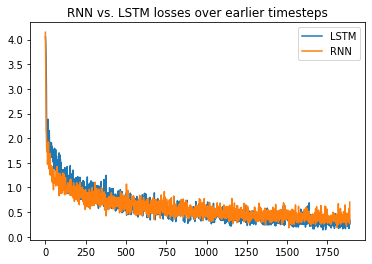

In [ ]:
plt.title("RNN vs. LSTM losses over earlier timesteps")
plt.plot(losses,label="LSTM")
plt.plot(rnn_losses, label="RNN")
#plt.xlim([0,800])
plt.legend()
plt.show()

In [ ]:
plt.title("RNN vs. LSTM eval losses")
plt.plot(eval_lstm,label="LSTM")
plt.plot(eval_rnn, label="RNN")
plt.xlim([0,800])
plt.legend()
plt.show()

# Part D: Using the LSTM model

## (1) Evaluation loss

Load the model you trained, and obtain a test loss. Your objective is to reach a **LSTM validation loss <= 0.4**
You should not need more than 10 epochs to attain the threshold. More passes over the data can however give you a better model. Other options include changing your optimizers, tuning your learning_rate, and using the last dropout layer. If you are running this validation and not training, run the setup cell above the training loop first.
Fill in the TODO's.

In [ ]:
model_id = "test11" # Make sure this id matches the id you assigned the LSTM model
save_dict = th.load(root_folder+'models/part1/'+f"model_{model_id}.pt",)
model = RecurrentClassifier(**save_dict['kwargs'],model_type='lstm')
model.load_state_dict(save_dict['model_state_dict'])
model.eval()

RecurrentClassifier(
  (embedding): Embedding(58, 256)
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.5)
  (output): Linear(in_features=256, out_features=58, bias=True)
)

In [ ]:
# Make sure your validation loss is below 0.4 and that you didn't train using
# the test set.

batch = build_batch(test_data, range(len(test_data)))
(batch_input, batch_target, batch_indices) = batch_to_torch(*batch)
prediction = model(batch_input.long())
loss = loss_fn(prediction, batch_target, batch_indices)
print("Evaluation set loss:", loss.item())

Evaluation set loss: 0.5559813976287842


In [ ]:
model.cpu()

## (2) Try your own name!

We can use our language model to generate text according to the distribution of our training data.
The way generation works is the following:

We seed the model with a beginning of sequence, and obtain the distribution for the next word.
We select the most likely word (argmax) and add it to our sequence of words.
Now our sequence is one word longer, and we can feed it in again as an input, for the network to produce the next sentence.
We do this a fixed number of times (up to 20 words), and obtain automatically generated headlines!


We have provided a few headline starters that should produce interesting generated headlines.

**TODO:** Get creative and find at least 2 more headline_starters that produce interesting headlines.

In [ ]:
def classify_name(name, model):
    '''
    Numerize the name and return the most likely number representation of the 
    predicted class.
    '''
    token = np.ones(19) * pad
    numerized = np.array([letterToIndex(l) for l in name])
    n = len(numerized)
    token[:n] = numerized
    logits = model(th.tensor(token)[None,:].long())
    logits_np = logits.detach().cpu().numpy()
    return np.argmax(logits_np[0,n-1,:])

In [ ]:
model.eval()
names= ['Sahai']
for name in names:
    print("===================")
    print("Predicting origin language for name: "+ name)
    c = classify_name(name, model)
    print(num_to_cat[c])

Classifying nationality for name: Sahai
Arabic


## All done

You are done with the first part of the HW.

Next notebook deals with Summarization of text!
